In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install --upgrade tensorflow-hub
!pip install tensorflow-text

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from transformers import AutoTokenizer, DataCollatorWithPadding

In [ ]:
# URL of the dataset from github
test_url = "https://raw.githubusercontent.com/Mafatihul/HarmonyGuard/main/ML/Dataset/test.csv"
train_url = "https://raw.githubusercontent.com/Mafatihul/HarmonyGuard/main/ML/Dataset/train.csv"

# Reading the content and turning it into a pandas dataframe
test_set = pd.read_csv(test_url)
train_set = pd.read_csv(train_url)

# Separate the label and sentences
train_sentences = train_set['Tweet']
train_labels = train_set[['HS', 'Abusive', 'HS_Religion', 'HS_Race', 'HS_Physical', 'HS_Gender', 'HS_Other']]

test_sentences = test_set['Tweet']
test_labels = test_set[['HS', 'Abusive', 'HS_Religion', 'HS_Race', 'HS_Physical', 'HS_Gender', 'HS_Other']]

In [ ]:
train_set.head()

,Tweet,HS,Abusive,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other
0,nak pergi jantung budak budak zaman main mercu...,0,0,0,0,0,0,0
1,assalamualaykum tidur dengar lagu nabi mandi g...,0,0,0,0,0,0,0
2,mental lgbt is wujud lahir kisah pengaruh beba...,0,0,0,0,0,0,0
3,tenaga kerja asing cina masuk indonesia masuk ...,1,0,0,1,0,0,0
4,rezim represif anti islam,1,0,1,0,0,0,0


In [ ]:
test_set.head()

,Tweet,HS,Abusive,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other
0,maaf foto halte taman anggrek tolong nama sih ...,0,0,0,0,0,0,0
1,lengser nih orang dasar kecut jokowi,1,0,0,0,0,0,1
2,lesbian teman lesbi,0,0,0,0,0,0,0
3,masyarakat provokasi isu sara main aktor jahat...,0,0,0,0,0,0,0
4,ya ampun rupiah asing banget,0,0,0,0,0,0,0


In [ ]:
# turn the labels into numpy array
train_labels_np = np.array(train_labels)
test_labels_np = np.array(test_labels)

In [ ]:
from transformers import BertTokenizer, TFBertModel

model_name='cahya/bert-base-indonesian-522M'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = TFBertModel.from_pretrained(model_name)
text = "Silakan diganti dengan text apa saja."
encoded_input = tokenizer(text, return_tensors='tf')
output = model(encoded_input)

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors='tf')

In [ ]:
max_seq_length = 17  # Adjust as needed
tokenizer = BertTokenizer.from_pretrained(model_name)
x_train = tokenizer(train_sentences.tolist(), truncation=True, padding=True, max_length=max_seq_length, return_tensors='tf')
x_test = tokenizer(test_sentences.tolist(), truncation=True, padding=True, max_length=max_seq_length, return_tensors='tf')

x_train()

In [ ]:
def create_model():
    input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_type_ids")

    Indo_Bert = TFBertModel.from_pretrained(model_name)
    outputs = Indo_Bert([input_word_ids, input_mask, input_type_ids])

    pooled_output = outputs.pooler_output  # Use the pooler output for classification

    output = tf.keras.layers.Dropout(0.4)(pooled_output)
    output = tf.keras.layers.Dense(128, activation='relu')(output)
    output = tf.keras.layers.Dense(64, activation='relu')(output)
    output = tf.keras.layers.Dense(64, activation='relu')(output)
    output = tf.keras.layers.Dense(7, activation='sigmoid')(output)

    model = tf.keras.Model(
        inputs={
            'input_word_ids': input_word_ids,
            'input_mask': input_mask,
            'input_type_ids': input_type_ids
        },
        outputs=output
    )
    return model


In [ ]:
model = create_model()

Epoch = 2
TRAINING_STEPS = len(x_train) * 10

lr_scheduler = keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=2e-5,
    end_learning_rate=0.0,
    decay_steps=TRAINING_STEPS
)


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'],
              run_eagerly=True)
model.summary()

Some layers from the model checkpoint at cahya/bert-base-indonesian-522M were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at cahya/bert-base-indonesian-522M.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 17)]                 0         []                            
 )                                                                                                
                                                                                                  
 input_mask (InputLayer)     [(None, 17)]                 0         []                            
                                                                                                  
 input_type_ids (InputLayer  [(None, 17)]                 0         []                            
 )                                                                                                
                                                                                            

model.summary()

In [ ]:
y_train = np.array(train_labels)

callback = tf.keras.callbacks.EarlyStopping(
    monitor='accuracy',
    patience=2,
    min_delta=0.01
)

x_train_tuple = (
    {"input_word_ids": x_train["input_ids"],
    "input_mask": x_train["attention_mask"],
    "input_type_ids": x_train["token_type_ids"]}
)

history = model.fit(x_train_tuple, y_train, validation_data=(x_test, test_labels_np), epochs=Epoch, batch_size=32, callbacks=[callback])

Epoch 1/2
318/318 [==============================] - 285s 824ms/step - loss: 0.3120 - accuracy: 0.7428 - val_loss: 0.6704 - val_accuracy: 1.0000
Epoch 2/2
318/318 [==============================] - 253s 797ms/step - loss: 0.2019 - accuracy: 0.7123 - val_loss: 0.6814 - val_accuracy: 1.0000


# Evaluating The Models

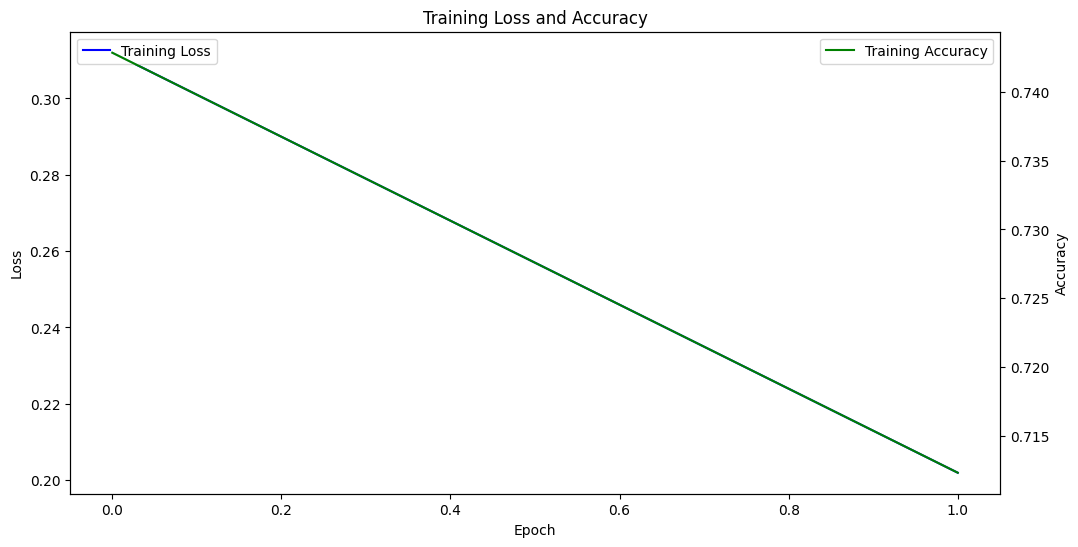

In [ ]:
import matplotlib.pyplot as plt

# Plot training loss and accuracy in a single plot
plt.figure(figsize=(12, 6))

# Plot training loss
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

# Create a secondary y-axis for accuracy
plt.twinx()
plt.plot(history.history['accuracy'], label='Training Accuracy', color='green')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')

plt.show()


In [ ]:
# Example comments for testing
test_comments = [
    "aktor huru hara 98 prabowo sih lengser perintah jokowi nyata",
    "bu guru enak jablay guru sekolah dasar sih kayak nikmat pecun guru",
    "pikir ampas banget ya",
    "Orang sunda cantik cantik",
    "Dasar gendut ga berguna",
    "Kamu Anjing",
    "Hai semuanya",
    "Hai ada apa ya btw",
    "Kamu kenapa?",
    "/s",
    "Hai saya anak yang baik",
    "Anjing bangsat",
    "woi lonte",
    "ahok cina k-fear",
    "banteng dinasti merajalela",
    "kenapa ya bisa begini?",
    "Alhamdulillah baik sekali",
    "jancok",
    "beurit teu sia",
    "si pace apa ka",
    "beta mau kesana",
    "bungul banar tambuk nih",
    "siap pak presiden",
    "om telolet om",
    "krisdayanti siap",
    "dapat qiqi ampas banget di banner alhaitham",
    "miawaug ganteng banget",
    "halo guys, david di sini",
    "nanda lemon",
    "kuru kuru",
    "bangsat kau",
    "ini dia biadab live lagi",
    "fuck"
    "nigga in the hood",
    "motherfucker ini kenapa sih",
    "kipas maspion andalan ku",
    "pengalaman aku adalah begini",
    "ashiap",
    "aku adalah graduate bangkit",
    "dijual ampas kopi hanya 1 rupiah",
    "manusia-manusia kontol",
    "anjing lu pada",
    "youtuber bangsat beraksi lagi",
    "mata lo keparat",
    "pak jokowi salah terus",
    "pak jokowi baik sekali",
    "Kita ampas seampas-ampasnya",
    "Jantan pukul betina",
    "Burung kuntul hidup di jendela",
    "cina-cina bangsat"
]

# Tokenize the test data
x_test = tokenizer(test_comments, truncation=True, padding=True, max_length=max_seq_length, return_tensors='tf')
x_test_tuple = (
    x_test['input_ids'],
    x_test['token_type_ids'],
    x_test['attention_mask']
)

# Make predictions
predictions = model.predict(x_test_tuple)

# Convert predictions to binary labels
threshold = 0.2125
binary_predictions = (predictions > threshold).astype(int)

# Map binary predictions to corresponding labels
label_names = ['HS', 'Abusive', 'HS_Religion', 'HS_Race', 'HS_Physical', 'HS_Gender', 'HS_Other']
predicted_labels = []

for pred_row in binary_predictions:
    labels = [label for label, pred in zip(label_names, pred_row) if pred == 1]
    predicted_labels.append(labels)

# Display results
for comment, labels in zip(test_comments, predicted_labels):
    print(f"Comment: {comment}")
    print(f"Predicted Labels: {labels}")
    print("\n")


2/2 [==============================] - 0s 211ms/step
Comment: aktor huru hara 98 prabowo sih lengser perintah jokowi nyata
Predicted Labels: []


Comment: bu guru enak jablay guru sekolah dasar sih kayak nikmat pecun guru
Predicted Labels: ['HS', 'HS_Other']


Comment: pikir ampas banget ya
Predicted Labels: ['HS', 'HS_Other']


Comment: Orang sunda cantik cantik
Predicted Labels: []


Comment: Dasar gendut ga berguna
Predicted Labels: ['HS', 'HS_Other']


Comment: Kamu Anjing
Predicted Labels: []


Comment: Hai semuanya
Predicted Labels: []


Comment: Hai ada apa ya btw
Predicted Labels: []


Comment: Kamu kenapa?
Predicted Labels: ['HS', 'HS_Other']


Comment: /s
Predicted Labels: ['HS', 'HS_Other']


Comment: Hai saya anak yang baik
Predicted Labels: []


Comment: Anjing bangsat
Predicted Labels: []


Comment: woi lonte
Predicted Labels: []


Comment: ahok cina k-fear
Predicted Labels: []


Comment: banteng dinasti merajalela
Predicted Labels: []


Comment: kenapa ya bisa begini?
Pr

In [ ]:
test_comments = [
    "aktor huru hara 98 prabowo sih lengser perintah jokowi nyata",
    "bu guru enak jablay guru sekolah dasar sih kayak nikmat pecun guru",
    "pikir ampas banget ya",
    "Orang sunda cantik cantik",
    "Dasar gendut ga berguna",
    "Kamu Anjing"
    # "Kamu orang nya baik banget"
]

x_test = tokenizer(test_comments, truncation=True, padding=True, max_length=max_seq_length, return_tensors='tf')
x_test_tuple = (
    x_test['input_ids'],
    x_test['token_type_ids'],
    x_test['attention_mask']
)

print(x_test.shape)
print(x_test_tuple.shape)

In [ ]:
# Make predictions
predictions = model.predict(x_test_tuple)

# Convert predictions to binary labels
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)

# Map binary predictions to corresponding labels
label_names = ['HS', 'Abusive', 'HS_Religion', 'HS_Race', 'HS_Physical', 'HS_Gender', 'HS_Other']
predicted_labels = []

In [ ]:
for pred_row in binary_predictions:
    labels = [label for label, pred in zip(label_names, pred_row) if pred == 1]
    predicted_labels.append(labels)

# Display results
for comment, labels in zip(test_comments, predicted_labels):
    print(f"Comment: {comment}")
    print(f"Predicted Labels: {labels}")
    print("\n")

In [ ]:
model.save("HarmonyGuard_ver0.1.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
